"""  
made by Kataoka @2023/12/XX.  
  
This is tutorial for PINNs and PyTorch.  
Build a model for predicting 2D cavity flow.  
"""  

# Import Libraries

In [1]:
# Standard Library

import os
import sys
import glob
from decimal import Decimal
import matplotlib.pyplot as plt

# External Library
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchviz import make_dot

# Settings

In [2]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
# device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data

In [3]:
def sample_points_cavity(
    num_sampling = 200000,
    num_sampling_left_edge = 10000,
    num_sampling_right_edge = 10000,
    num_sampling_bottom_edge = 10000,
    num_sampling_top_edge = 10000,
    num_sampling_init = 10000,
    continuous_time=True,
    size = 1,
    maxtime = 1,
    dt = 0.1,
    beta = None
):
    """
    docstring
        
    """

    points_dict = {}

    # sampling for continuous time
    if continuous_time==True:
        
        # within the region
        points_dict["residual"] = sample_from_Rectangular(num_sampling=num_sampling, x_size=size, y_size=size, z_size=maxtime)
        
        # boundary
        temp_array = sample_from_Square(num_sampling=num_sampling_left_edge, x_size=size, y_size=maxtime)
        points_dict["left_edge"] = np.concatenate([np.full((num_sampling_left_edge, 1), 0), temp_array], axis=1)
        
        temp_array = sample_from_Square(num_sampling=num_sampling_right_edge, x_size=size, y_size=maxtime)
        points_dict["right_edge"] = np.concatenate([np.full((num_sampling_right_edge, 1), size), temp_array], axis=1)
        
        temp_array = sample_from_Square(num_sampling=num_sampling_bottom_edge, x_size=size, y_size=maxtime)
        points_dict["bottom_edge"] = \
            np.concatenate([temp_array[:,0:1], np.full((num_sampling_bottom_edge, 1), 0), temp_array[:,1:2]], axis=1)
        
        temp_array = sample_from_Square(num_sampling=num_sampling_top_edge, x_size=size, y_size=maxtime)
        points_dict["top_edge"] = \
            np.concatenate([temp_array[:,0:1], np.full((num_sampling_top_edge, 1), size), temp_array[:,1:2]], axis=1)

        # initial
        temp_array = sample_from_Square(num_sampling=num_sampling_init, x_size=size, y_size=size)
        points_dict["init"] = np.concatenate([temp_array, np.full((num_sampling_init, 1), 0)], axis=1)

        
    # sampling for discrete time        
    else:
        maxstep = int(Decimal(str(maxtime))/Decimal(str(dt)))
        
        # correction
        if beta==None:
            beta = maxstep

        num_sampling = int(num_sampling/beta)
        num_sampling_left_edge = int(num_sampling_left_edge/beta)
        num_sampling_right_edge = int(num_sampling_right_edge/beta)
        num_sampling_bottom_edge = int(num_sampling_bottom_edge/beta)
        num_sampling_top_edge = int(num_sampling_top_edge/beta)

        # within the region
        res = sample_from_Square(num_sampling=num_sampling, x_size=size, y_size=size)

        # res and boundary
        temp_array = sample_from_Line(num_sampling=num_sampling_left_edge, x_size=size)
        left_edge = np.concatenate([np.full((num_sampling_left_edge, 1), 0), temp_array], axis=1)

        temp_array = sample_from_Line(num_sampling=num_sampling_right_edge, x_size=size)
        right_edge = np.concatenate([np.full((num_sampling_right_edge, 1), size), temp_array], axis=1)

        temp_array = sample_from_Line(num_sampling=num_sampling_bottom_edge, x_size=size)
        bottom_edge = np.concatenate([temp_array, np.full((num_sampling_bottom_edge, 1), 0)], axis=1)

        temp_array = sample_from_Line(num_sampling=num_sampling_top_edge, x_size=size)
        top_edge = np.concatenate([temp_array, np.full((num_sampling_top_edge, 1), size)], axis=1)

        # initialize dict
        points_dict["res"] = np.concatenate([res, np.full((len(res), 1), dt)], axis=1)
        points_dict["left_edge"] = np.concatenate([left_edge, np.full((len(left_edge), 1), dt)], axis=1)
        points_dict["right_edge"] = np.concatenate([right_edge, np.full((len(right_edge), 1), dt)], axis=1)
        points_dict["bottom_edge"] = np.concatenate([bottom_edge, np.full((len(bottom_edge), 1), dt)], axis=1)
        points_dict["top_edge"] = np.concatenate([top_edge, np.full((len(top_edge), 1), dt)], axis=1)

        for i in range(2, maxstep+1):
            for key,array in zip(list(points_dict.keys()), [res, left_edge, right_edge, bottom_edge, top_edge]):

                points_dict[key] = np.concatenate([points_dict[key], np.concatenate([array, np.full((len(array), 1), i*dt)], axis=1)])

        # initial
        temp_array = np.concatenate([res, left_edge, right_edge, bottom_edge, top_edge], axis=0)
        points_dict["init"] = np.concatenate([temp_array, np.full((len(temp_array), 1), 0)], axis=1)
    
    return points_dict



def sample_from_Rectangular(
    num_sampling, 
    x_size,
    y_size,
    z_size,
    x_min = 0,
    y_min = 0,
    z_min = 0
):
    """
    sample points from a recranglar region.
    
    Args:
        num_sampling : int / number of sampling points
        x_size : int or float / rectangular length for x
        y_size : int or float / rectangular length for y
        z_size : int or float / rectangular length for z
        x_min = 0 : int or float / minimum value x of sampling range. sample from [x_min, x_min+x_size]
        y_min = 0 : int or float / minimum value y of sampling range. sample from [y_min, y_min+y_size]
        z_min = 0 : int or float / minimum value z of sampling range. sample from [z_min, z_min+z_size]

    Returns:
        points_array: np.ndarray / set of points
    """
    
    points_array = np.random.rand(num_sampling, 3)
    
    size_array = \
        np.concatenate([np.full((num_sampling, 1),x_size), np.full((num_sampling, 1),y_size), np.full((num_sampling, 1),z_size)], axis=1)
    min_array = \
        np.concatenate([np.full((num_sampling, 1),x_min), np.full((num_sampling, 1),y_min), np.full((num_sampling, 1),z_min)], axis=1)

    return points_array * size_array - min_array



def sample_from_Square(
    num_sampling, 
    x_size,
    y_size,
    x_min = 0,
    y_min = 0,
):
    """
    sample points from a square region.

    Args:
        num_sampling : int / number of sampling points
        x_size : int or float / rectangular length for x
        y_size : int or float / rectangular length for y
        x_min : int or float / minimum value x of sampling range. sample from [x_min, x_min+x_size]
        y_min : int or float / minimum value y of sampling range. sample from [y_min, y_min+y_size]

    Returns:
        points_array: np.ndarray / set of points
    """

    points_array = np.random.rand(num_sampling, 2)
    
    size_array = np.concatenate([np.full((num_sampling, 1),x_size), np.full((num_sampling, 1),y_size)], axis=1)
    min_array = np.concatenate([np.full((num_sampling, 1),x_min), np.full((num_sampling, 1),y_min)], axis=1)

    return points_array * size_array - min_array



def sample_from_Line(
    num_sampling, 
    x_size,
    x_min = 0,
):
    """
    sample points from a line region.

    Args:
        num_sampling : int or float / number of sampling points
        x_size : int or float / rectangular length for x
        x_min : int or float / minimum value x of sampling range. sample from [x_min, x_min+x_size]

    Returns:
        points_array: np.ndarray / set of points
    """
    
    points_array = np.random.rand(num_sampling, 1)
    
    size_array = np.concatenate([np.full((num_sampling, 1),x_size)], axis=1)
    min_array = np.concatenate([np.full((num_sampling, 1),x_min)], axis=1)

    return points_array * size_array - min_array

# Visualization

In [4]:
def plot_residual2D(
    data,
    region_map
):
    """
    docstring
    """
    
    fig = plt.figure(figsize = (6, 6))
    ax = fig.add_subplot(111)
    
    ax.set_xlabel("x", size = 14)
    ax.set_ylabel("y", size = 14)
    
    c_map = ["black", "blue", "green", "red"]
    
    for i,key in enumerate(list(data.keys())):
        ax.scatter(data[key][:,0], data[key][:,1], s=0.1, color=c_map[region_map[i]])
    
    plt.show()
    
    return


def plot_residual3D(
    data,
    region_map
):
    """
    docstring
    """
    
    fig = plt.figure(figsize = (6, 6))
    ax = fig.add_subplot(111, projection="3d")
    
    ax.set_xlabel("x", size = 14)
    ax.set_ylabel("t", size = 14)
    ax.set_zlabel("y", size = 14)
    
    c_map = ["black", "blue", "green", "red"]
    
    for i,key in enumerate(list(data.keys())):
        ax.scatter(data[key][:,0], data[key][:,2], data[key][:,1], s=0.1, color=c_map[region_map[i]])
        
    plt.show()
    
    return


def plot_Vector2D(
    X, Y, U, V, scale=1
):
    """
    docstring
    """
    
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_subplot(111)
    
    Q = ax.quiver(X, Y, scale*U, scale*V, (U**2+V**2)**0.5, cmap="jet", angles="xy", scale_units="xy", scale=1)
    
    ax.set_xlabel("x", size = 14)
    ax.set_ylabel("y", size = 14)
    ax.set_facecolor("black")
    ax.set_xlim(min(X), max(X))
    ax.set_ylim(min(Y), max(Y))
    ax.set_aspect("equal")
    
    fig.colorbar(Q, label="velocity")
    
    plt.show()
    
    return fig


def plot_Scalar2D(
    X, Y, img, split=5
):
    """
    docstring
    """
    
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_subplot(111)
    
    Q = ax.imshow(img, cmap="jet")
    
    X = X.reshape(-1)
    Y = Y.reshape(-1)
    
    height = img.shape[0]
    width = img.shape[1]
    
    ax.set_xlabel("x", size = 14)
    ax.set_ylabel("y", size = 14)
    ax.set_xticks(np.linspace(0, width-1, split+1))
    ax.set_yticks(np.linspace(0, height-1, split+1))
    ax.set_xticklabels(np.round(np.linspace(min(X), max(X), split+1),3))
    ax.set_yticklabels(np.round(np.linspace(min(Y), max(Y), split+1),3)[::-1])

    ax.set_aspect("equal")
    
    fig.colorbar(Q, label="velocity")
    
    plt.show()
    
    return

# Physics-Informed Neural Networks

In [5]:
class DNN(nn.Module):

    def __init__(self, input_size, output_size, num_layer, num_neuron):
        
        super(DNN, self).__init__()
        
        # Instance Variable
        self.input_size = input_size
        self.output_size = output_size
        self.num_layer = num_layer
        self.num_neuron = num_neuron

        self.inputs = nn.Linear(input_size, num_neuron)
        self.fc1 = nn.Linear(num_neuron, num_neuron)
        self.fc2 = nn.Linear(num_neuron, num_neuron)
        self.fc3 = nn.Linear(num_neuron, num_neuron)
        #self.fc4 = nn.Linear(num_neuron, num_neuron)
        #self.fc5 = nn.Linear(num_neuron, num_neuron)
        self.outputs = nn.Linear(num_neuron, output_size)
        
        self.activation = nn.Tanh()
        
        return

        
    def forward(self, x):
            
        x = self.activation(self.inputs(x))
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        #x = self.activation(self.fc4(x))
        #x = self.activation(self.fc5(x))
        x = self.outputs(x)
        
        return x

In [6]:
class PhysicsInformedNN():
    def __init__(self, input_size, output_size, num_layer, num_neuron, X, U, Re):
        
        # Data
        self.x_res = torch.tensor(X["res"][:, 0:1], requires_grad=True).float().to(device)
        self.y_res = torch.tensor(X["res"][:, 1:2], requires_grad=True).float().to(device)
        self.t_res = torch.tensor(X["res"][:, 2:3], requires_grad=True).float().to(device)
        
        self.x_bound = torch.tensor(X["bound"][:, 0:1], requires_grad=True).float().to(device)
        self.y_bound = torch.tensor(X["bound"][:, 1:2], requires_grad=True).float().to(device)
        self.t_bound = torch.tensor(X["bound"][:, 2:3], requires_grad=True).float().to(device)
        self.u_bound = torch.tensor(U["bound"][:, 0:1]).float().to(device)
        self.v_bound = torch.tensor(U["bound"][:, 1:2]).float().to(device)
        
        self.x_init = torch.tensor(X["init"][:, 0:1], requires_grad=True).float().to(device)
        self.y_init = torch.tensor(X["init"][:, 1:2], requires_grad=True).float().to(device)
        self.t_init = torch.tensor(X["init"][:, 2:3], requires_grad=True).float().to(device)
        self.u_init = torch.tensor(U["init"][:, 0:1]).float().to(device)
        self.v_init = torch.tensor(U["init"][:, 1:2]).float().to(device)
        
        # Reynolds Number
        self.Re = Re
        
        # Loss History
        self.loss_history = {"init": [], "bound": [], "res": [], "total": []}
        
        # Deep Neural Networks
        self.dnn = DNN(input_size, output_size, num_layer, num_neuron).to(device)
        #self.optimizer = torch.optim.Adam(self.dnn.parameters())
        self.optimizer = torch.optim.LBFGS(self.dnn.parameters(), lr=0.5, max_iter=10)
        
        
    def net_u(self, x, y, t):  
        
        outputs = self.dnn(torch.cat([x, y, t], dim=1).to(device))
        u = outputs[:, 0:1]
        v = outputs[:, 1:2]
        p = outputs[:, 2:3]
        
        return u, v, p

    
    def net_f(self, x, y, t):

        u, v, p = self.net_u(x, y, t)
        
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), retain_graph=True, create_graph=True)[0]

        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), retain_graph=True, create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), retain_graph=True, create_graph=True)[0]
        
        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True)[0]
        p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True)[0]        
        
        f_x = u_t + u * u_x + v * u_y + p_x - 1/self.Re * (u_xx + u_yy)
        f_y = v_t + u * v_x + v * v_y + p_y - 1/self.Re * (v_xx + v_yy)
        f_continue = u_x + v_y
        
        return f_x, f_y, f_continue
    
    
    def train(self, nIter):
        
        self.dnn.train()
        
        # Initial Loss
        u_pred_init, v_pred_init, p_pred_init = self.net_u(self.x_init, self.y_init, self.t_init)
        u_pred_bound, v_pred_bound, p_pred_bound = self.net_u(self.x_bound, self.y_bound, self.t_bound)
        f_pred_x, f_pred_y, f_pred_continue = self.net_f(self.x_res, self.y_res, self.t_res)
        
        init_loss = torch.mean((self.u_init - u_pred_init) ** 2) + torch.mean((self.v_init - v_pred_init) ** 2)
        bound_loss = torch.mean((self.u_bound - u_pred_bound) ** 2) + torch.mean((self.v_bound - v_pred_bound) ** 2)
        res_loss = torch.mean(f_pred_x ** 2 + f_pred_y ** 2 + f_pred_continue ** 2)

        loss = init_loss + 10*bound_loss + res_loss
        
        print(
            "Epoch: 0, init_Loss: %.6f, boundary_Loss: %.6f, residual_Loss: %.6f, total_loss: %.6f" % 
            (
                init_loss.item(),
                bound_loss.item(), 
                res_loss.item(), 
                loss.item()
            )
        )
        
        # Training
        for epoch in range(1, nIter+1):

            def closure():
                self.optimizer.zero_grad()
            
                u_pred_init, v_pred_init, p_pred_init = self.net_u(self.x_init, self.y_init, self.t_init)
                u_pred_bound, v_pred_bound, p_pred_bound = self.net_u(self.x_bound, self.y_bound, self.t_bound)
                f_pred_x, f_pred_y, f_pred_continue = self.net_f(self.x_res, self.y_res, self.t_res)

                init_loss = torch.mean((self.u_init - u_pred_init) ** 2) + torch.mean((self.v_init - v_pred_init) ** 2)
                bound_loss = torch.mean((self.u_bound - u_pred_bound) ** 2) + torch.mean((self.v_bound - v_pred_bound) ** 2)
                res_loss = torch.mean(f_pred_x ** 2 + f_pred_y ** 2 + f_pred_continue ** 2)

                loss = init_loss + 10*bound_loss + res_loss
                loss.backward()
                
                return loss

            self.optimizer.step(closure)

            # calculate the loss again for monitoring
            u_pred_init, v_pred_init, p_pred_init = self.net_u(self.x_init, self.y_init, self.t_init)
            u_pred_bound, v_pred_bound, p_pred_bound = self.net_u(self.x_bound, self.y_bound, self.t_bound)
            f_pred_x, f_pred_y, f_pred_continue = self.net_f(self.x_res, self.y_res, self.t_res)

            init_loss = torch.mean((self.u_init - u_pred_init) ** 2) + torch.mean((self.v_init - v_pred_init) ** 2)
            bound_loss = torch.mean((self.u_bound - u_pred_bound) ** 2) + torch.mean((self.v_bound - v_pred_bound) ** 2)
            res_loss = torch.mean(f_pred_x ** 2 + f_pred_y ** 2 + f_pred_continue ** 2)

            loss = init_loss + 10*bound_loss + res_loss
            
            #self.optimizer.zero_grad()
            #loss.backward()
            #self.optimizer.step()
            
            # Output display & Record history
            if epoch%10==0:
                print(
                    "Epoch: %d, init_Loss: %.6f, boundary_Loss: %.6f, residual_Loss: %.6f, total_loss: %.6f" % 
                    (
                        epoch,
                        init_loss.item(),
                        bound_loss.item(), 
                        res_loss.item(), 
                        loss.item()
                    )
                )
                self.loss_history["init"].append(loss.item())
                self.loss_history["bound"].append(loss.item())
                self.loss_history["res"].append(res_loss.item())
                self.loss_history["total"].append(bound_loss.item())
            
            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        y = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 2:3], requires_grad=True).float().to(device)
        
        self.dnn.eval()
        u, v, p = self.net_u(x, y, t)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        p = p.detach().cpu().numpy()
        
        return u, v, p

# Main


In [7]:
# Representative Value
rep_length = 0.1
rep_velocity = 1.0
rep_viscosity = 0.01

Re = (rep_length * rep_velocity) / rep_viscosity


# Sampling residual points

residual_points = sample_points_cavity(
                                        num_sampling = 2000,
                                        num_sampling_left_edge = 333,
                                        num_sampling_right_edge = 333,
                                        num_sampling_bottom_edge = 334,
                                        num_sampling_top_edge = 1000,
                                        num_sampling_init = 999999,
                                        continuous_time=False,
                                        size = 1,
                                        maxtime = 0.3,
                                        dt = 0.01,
                                        beta = 1
                                        )
                                        
"""
residual_points = sample_points_cavity(
                                        num_sampling = 150000,
                                        num_sampling_left_edge = 20000,
                                        num_sampling_right_edge = 20000,
                                        num_sampling_bottom_edge = 20000,
                                        num_sampling_top_edge = 40000,
                                        num_sampling_init = 20000,
                                        continuous_time=True,
                                        size = 1,
                                        maxtime = 1,
                                        dt = 0.01,
                                        beta = 1
                                        )
"""

X = {}
#X["res"] = residual_points["top_edge"]
X["res"] = np.empty(shape=(0,3))
for key in list(residual_points.keys()):
    X["res"] = np.concatenate([X["res"], residual_points[key]], axis=0)
X["bound"] = np.empty(shape=(0,3))
for key in ["left_edge", "right_edge", "bottom_edge", "top_edge"]:
    X["bound"] = np.concatenate([X["bound"], residual_points[key]], axis=0)
X["init"] = residual_points["init"]


# velocity teaching data
U = {}

# initial condition
u_init = np.full((len(residual_points["init"]), 1), 0)
v_init = np.full((len(residual_points["init"]), 1), 0)
U["init"] = np.concatenate([u_init, v_init], axis=1)

# boundary condition
U["bound"] = np.empty(shape=(0,2))
for key in ["left_edge", "right_edge", "bottom_edge"]:
    u_bound = np.full((len(residual_points[key]), 1), 0)
    v_bound = np.full((len(residual_points[key]), 1), 0)
    U_bound = np.concatenate([u_bound, v_bound], axis=1)
    U["bound"] = np.concatenate([U["bound"], U_bound], axis=0)

u_bound = np.full((len(residual_points["top_edge"]), 1), 1)
v_bound = np.full((len(residual_points["top_edge"]), 1), 0)
U_bound = np.concatenate([u_bound, v_bound], axis=1)
U["bound"] = np.concatenate([U["bound"], U_bound], axis=0)

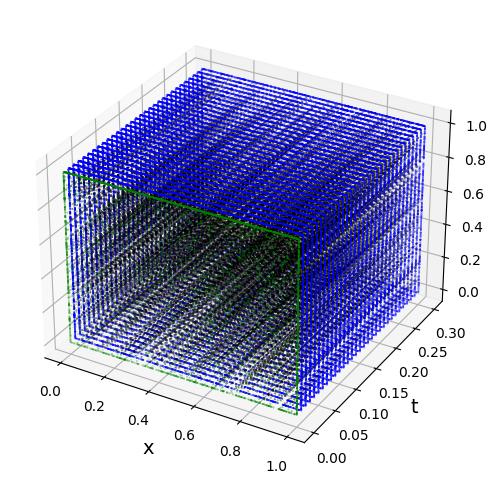

In [8]:
plot_residual3D(residual_points, [0,1,1,1,1,2])

In [9]:
input_size = 3
output_size = 3
num_layer = 6
num_neuron = 50

model = PhysicsInformedNN(input_size, output_size, num_layer, num_neuron, X, U, Re)

In [10]:
model.train(3000)

Epoch: 0, init_Loss: 0.045833, boundary_Loss: 0.334026, residual_Loss: 0.012368, total_loss: 3.398458
Epoch: 10, init_Loss: 0.150449, boundary_Loss: 0.026303, residual_Loss: 0.021543, total_loss: 0.435023
Epoch: 20, init_Loss: 0.130252, boundary_Loss: 0.021718, residual_Loss: 0.020865, total_loss: 0.368301
Epoch: 30, init_Loss: 0.105012, boundary_Loss: 0.020466, residual_Loss: 0.020208, total_loss: 0.329880
Epoch: 40, init_Loss: 0.089543, boundary_Loss: 0.020210, residual_Loss: 0.017318, total_loss: 0.308963
Epoch: 50, init_Loss: 0.078756, boundary_Loss: 0.019143, residual_Loss: 0.018322, total_loss: 0.288505
Epoch: 60, init_Loss: 0.066183, boundary_Loss: 0.019128, residual_Loss: 0.017121, total_loss: 0.274580
Epoch: 70, init_Loss: 0.061518, boundary_Loss: 0.018648, residual_Loss: 0.018247, total_loss: 0.266244
Epoch: 80, init_Loss: 0.056204, boundary_Loss: 0.018199, residual_Loss: 0.018930, total_loss: 0.257128
Epoch: 90, init_Loss: 0.050555, boundary_Loss: 0.017820, residual_Loss: 0.

Epoch: 790, init_Loss: 0.002455, boundary_Loss: 0.006880, residual_Loss: 0.017210, total_loss: 0.088465
Epoch: 800, init_Loss: 0.002566, boundary_Loss: 0.006833, residual_Loss: 0.017207, total_loss: 0.088104
Epoch: 810, init_Loss: 0.002630, boundary_Loss: 0.006773, residual_Loss: 0.017340, total_loss: 0.087704
Epoch: 820, init_Loss: 0.002487, boundary_Loss: 0.006781, residual_Loss: 0.017035, total_loss: 0.087335
Epoch: 830, init_Loss: 0.002403, boundary_Loss: 0.006702, residual_Loss: 0.017253, total_loss: 0.086673
Epoch: 840, init_Loss: 0.002267, boundary_Loss: 0.006679, residual_Loss: 0.016940, total_loss: 0.086001
Epoch: 850, init_Loss: 0.002244, boundary_Loss: 0.006701, residual_Loss: 0.016332, total_loss: 0.085582
Epoch: 860, init_Loss: 0.002274, boundary_Loss: 0.006679, residual_Loss: 0.016234, total_loss: 0.085293
Epoch: 870, init_Loss: 0.002353, boundary_Loss: 0.006620, residual_Loss: 0.016356, total_loss: 0.084913
Epoch: 880, init_Loss: 0.002371, boundary_Loss: 0.006575, residu

Epoch: 1580, init_Loss: 0.001750, boundary_Loss: 0.004478, residual_Loss: 0.014164, total_loss: 0.060692
Epoch: 1590, init_Loss: 0.001734, boundary_Loss: 0.004455, residual_Loss: 0.014187, total_loss: 0.060474
Epoch: 1600, init_Loss: 0.001748, boundary_Loss: 0.004446, residual_Loss: 0.014017, total_loss: 0.060225
Epoch: 1610, init_Loss: 0.001851, boundary_Loss: 0.004427, residual_Loss: 0.013931, total_loss: 0.060053
Epoch: 1620, init_Loss: 0.001870, boundary_Loss: 0.004417, residual_Loss: 0.013836, total_loss: 0.059871
Epoch: 1630, init_Loss: 0.001870, boundary_Loss: 0.004394, residual_Loss: 0.013872, total_loss: 0.059682
Epoch: 1640, init_Loss: 0.001913, boundary_Loss: 0.004358, residual_Loss: 0.014002, total_loss: 0.059495
Epoch: 1650, init_Loss: 0.001936, boundary_Loss: 0.004332, residual_Loss: 0.014044, total_loss: 0.059304
Epoch: 1660, init_Loss: 0.001959, boundary_Loss: 0.004301, residual_Loss: 0.014125, total_loss: 0.059093
Epoch: 1670, init_Loss: 0.001899, boundary_Loss: 0.0042

Epoch: 2370, init_Loss: 0.001370, boundary_Loss: 0.003278, residual_Loss: 0.011074, total_loss: 0.045224
Epoch: 2380, init_Loss: 0.001376, boundary_Loss: 0.003239, residual_Loss: 0.011254, total_loss: 0.045019
Epoch: 2390, init_Loss: 0.001377, boundary_Loss: 0.003242, residual_Loss: 0.011057, total_loss: 0.044852
Epoch: 2400, init_Loss: 0.001375, boundary_Loss: 0.003235, residual_Loss: 0.010931, total_loss: 0.044653
Epoch: 2410, init_Loss: 0.001375, boundary_Loss: 0.003236, residual_Loss: 0.010756, total_loss: 0.044493
Epoch: 2420, init_Loss: 0.001391, boundary_Loss: 0.003222, residual_Loss: 0.010737, total_loss: 0.044350
Epoch: 2430, init_Loss: 0.001364, boundary_Loss: 0.003222, residual_Loss: 0.010646, total_loss: 0.044231
Epoch: 2440, init_Loss: 0.001383, boundary_Loss: 0.003210, residual_Loss: 0.010630, total_loss: 0.044113
Epoch: 2450, init_Loss: 0.001400, boundary_Loss: 0.003208, residual_Loss: 0.010499, total_loss: 0.043980
Epoch: 2460, init_Loss: 0.001381, boundary_Loss: 0.0032

In [11]:
x = np.linspace(0, 1, 30)
y = np.linspace(0, 1, 30)
X, Y = np.meshgrid(x, y)

temp = np.concatenate([X.reshape((-1,1)),Y.reshape((-1,1)), np.full((len(X.reshape((-1,1))),1),0.3)], axis=1)
u, v, p = model.predict(temp)

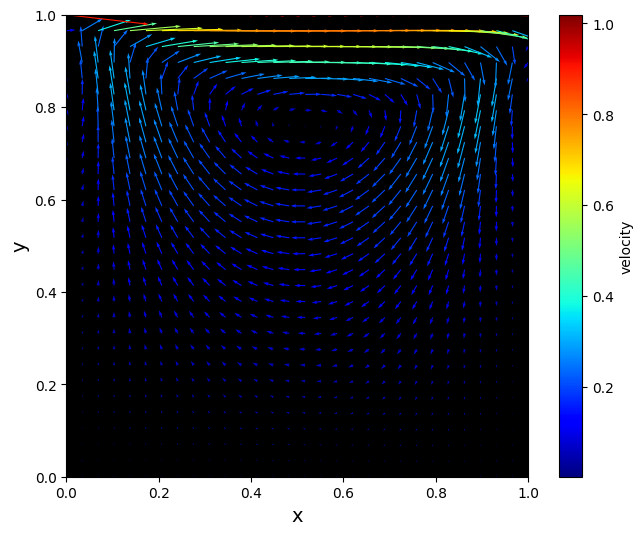

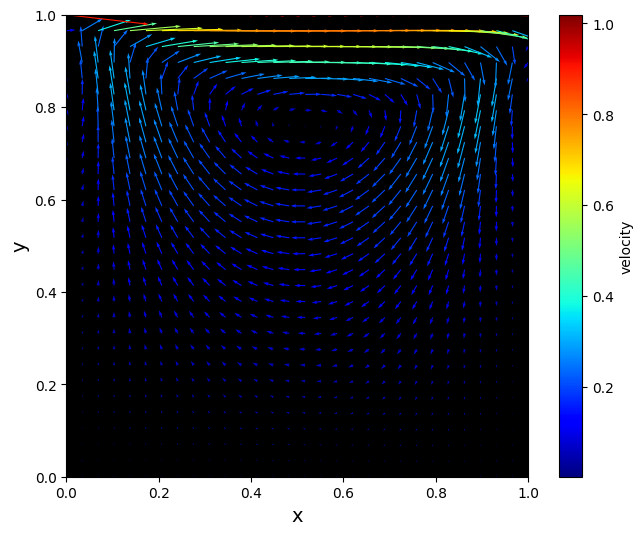

In [12]:
plot_Vector2D(X.reshape((-1,1)), Y.reshape((-1,1)), u, v, scale=0.2)

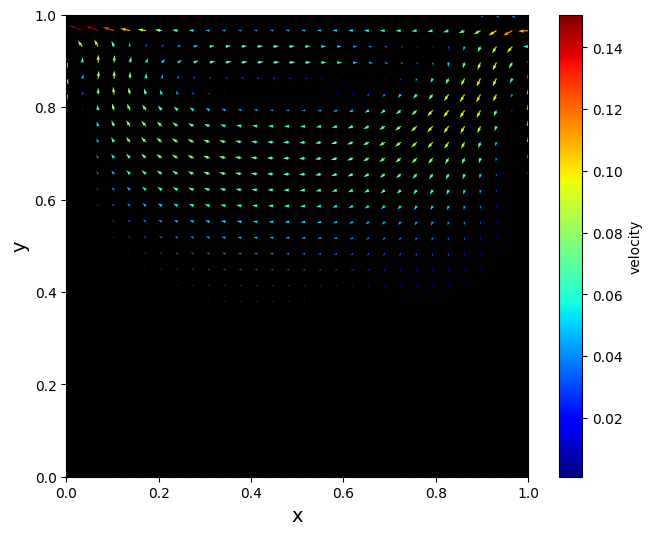

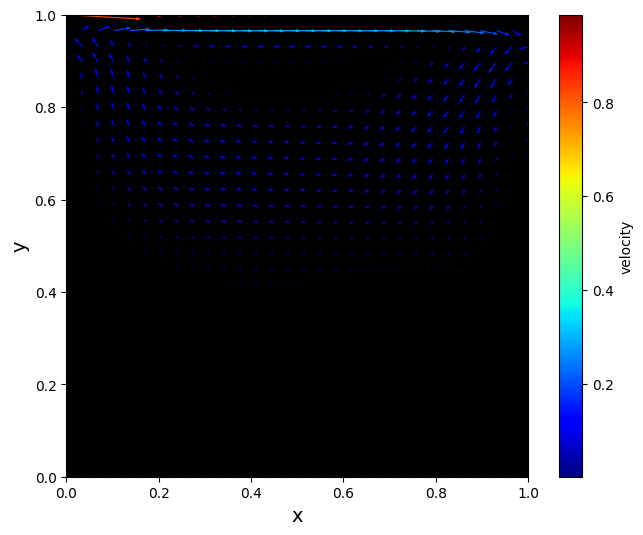

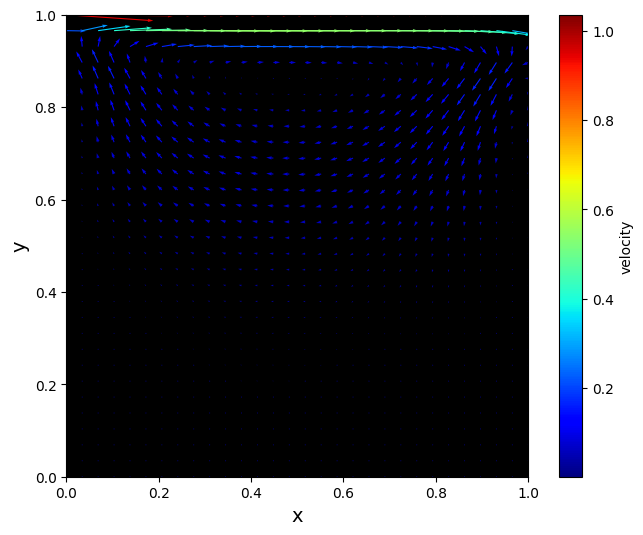

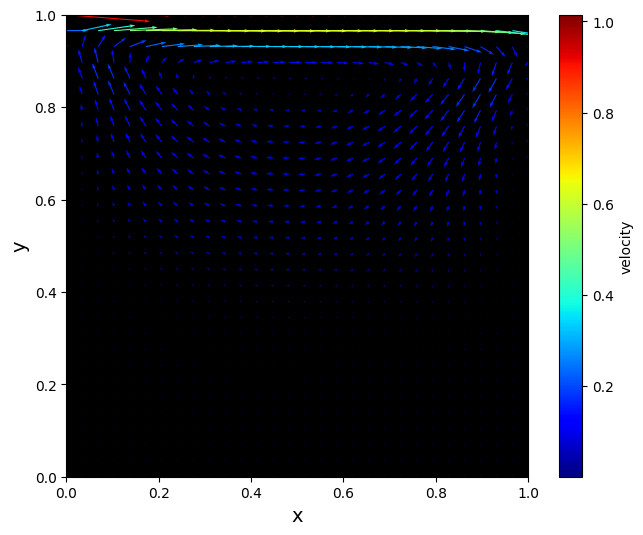

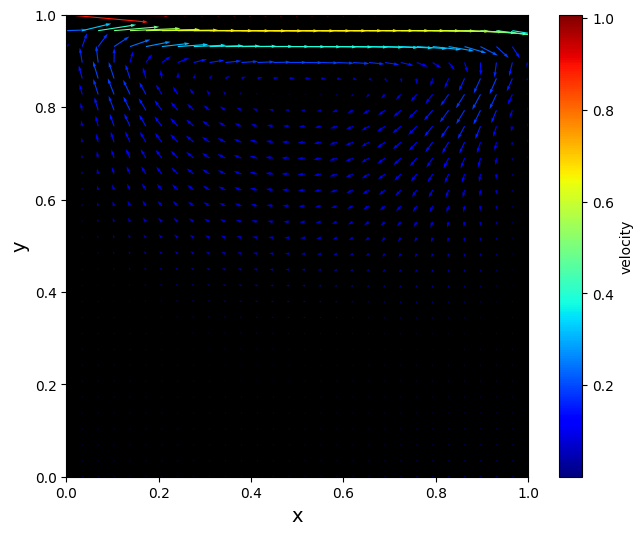

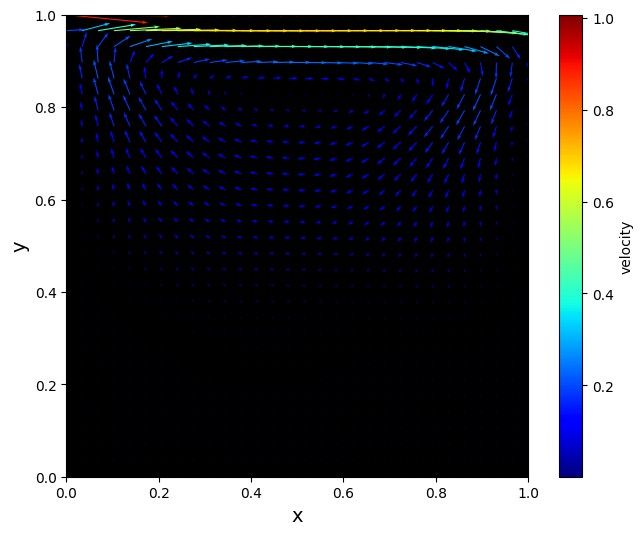

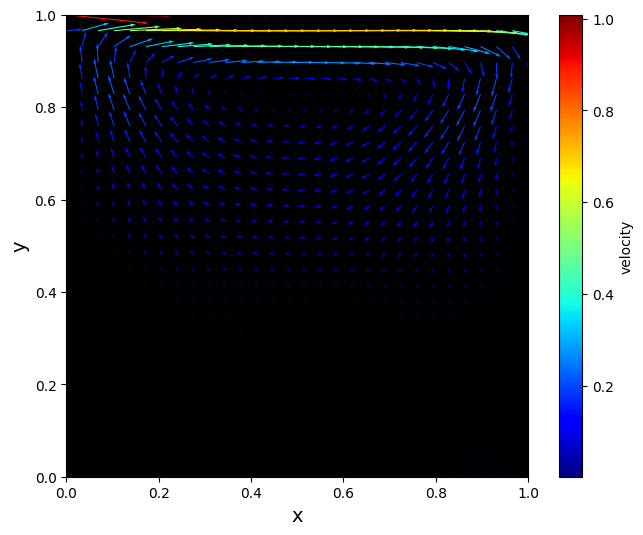

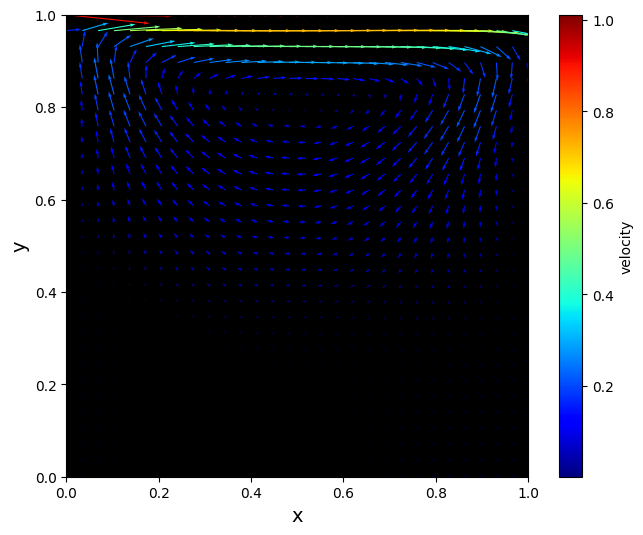

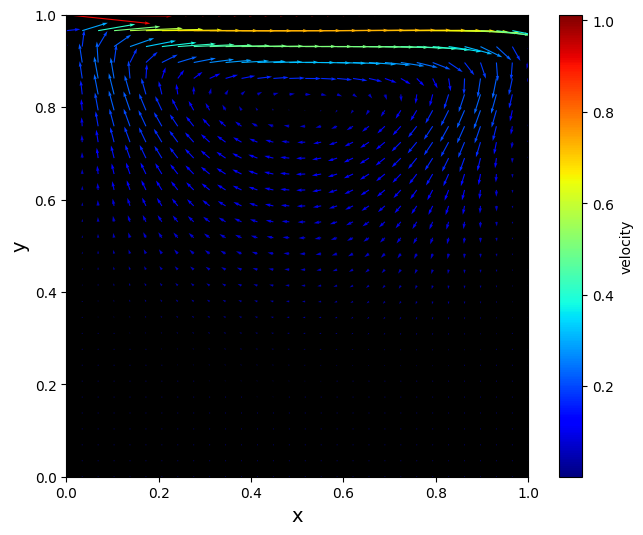

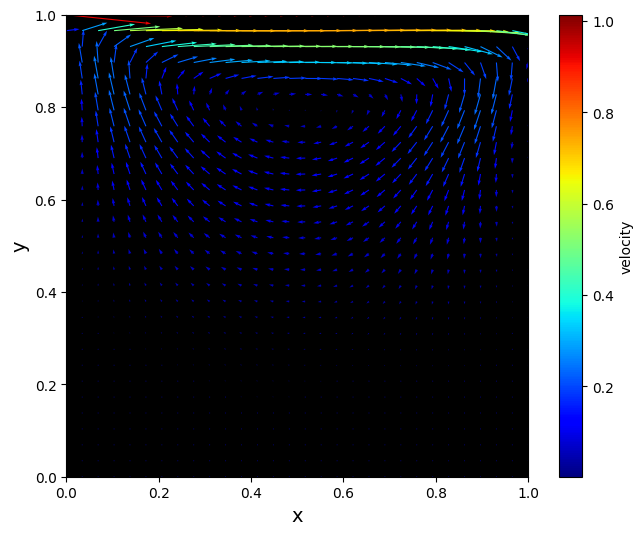

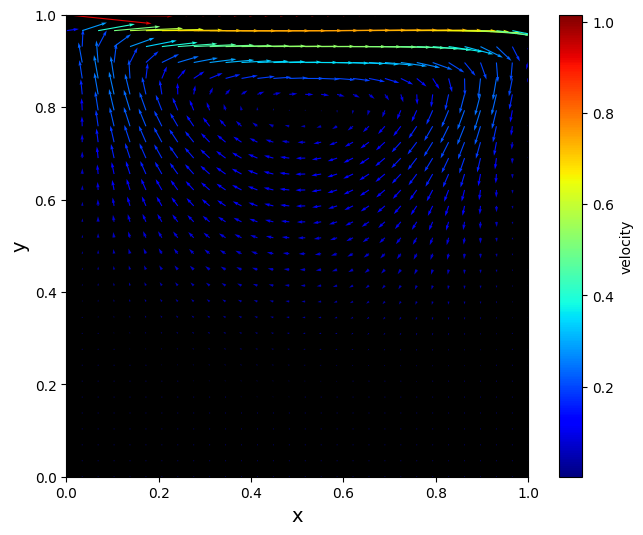

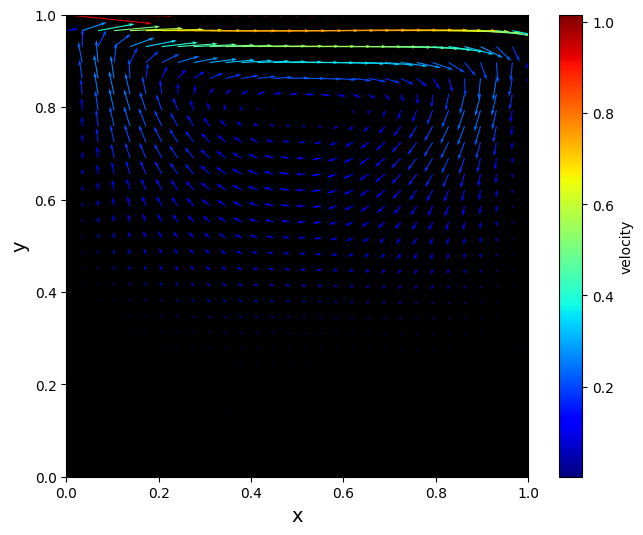

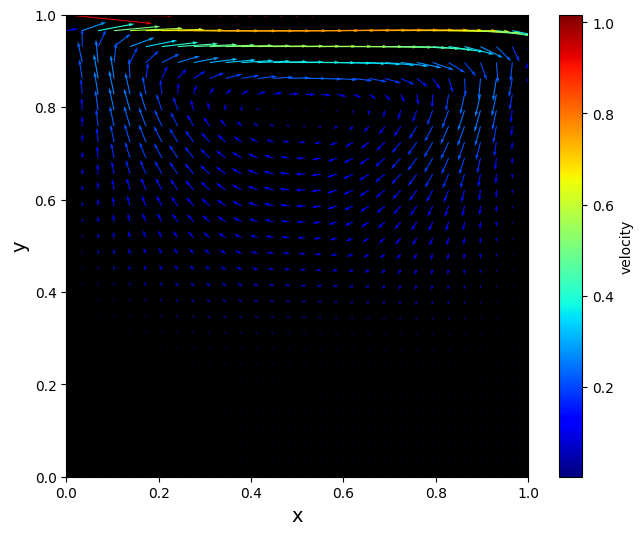

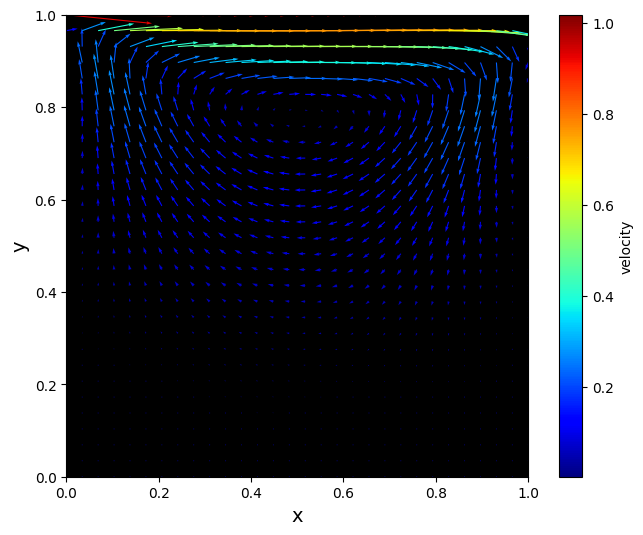

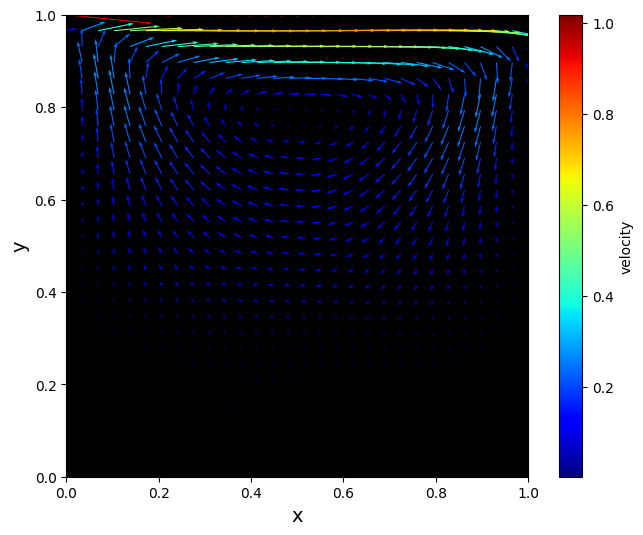

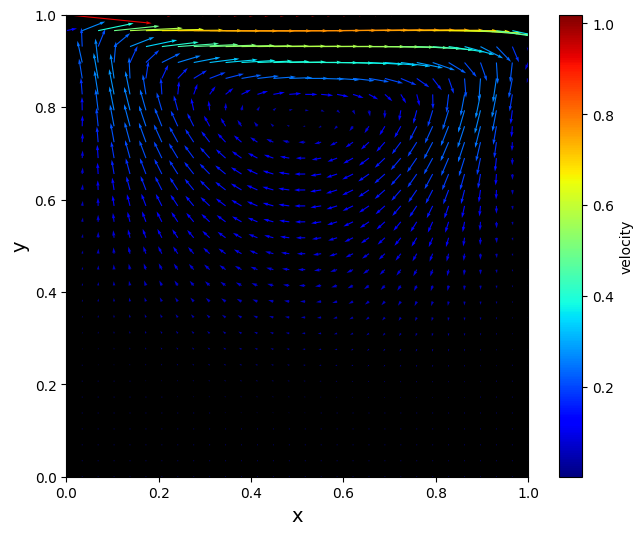

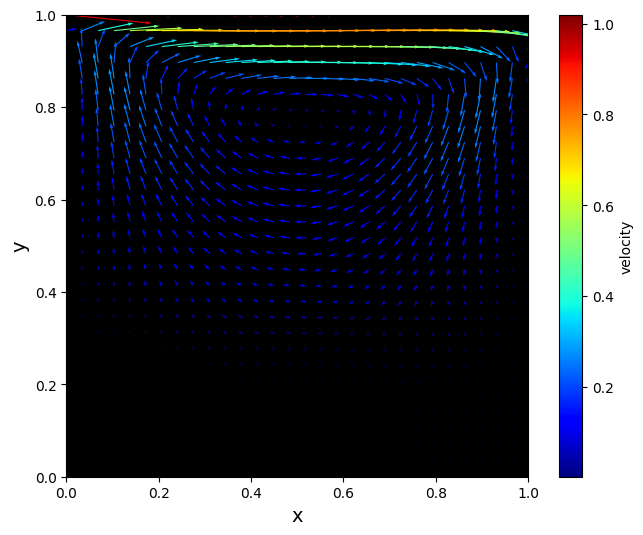

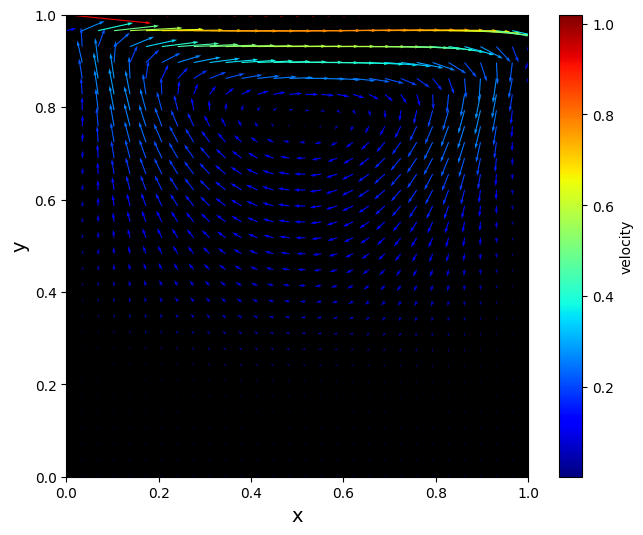

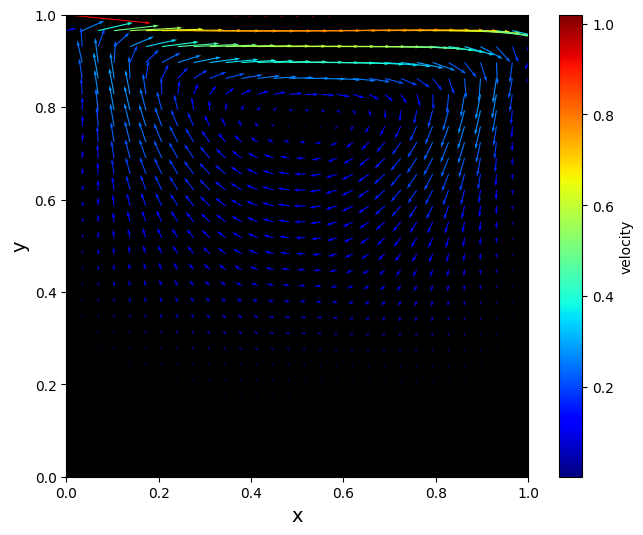

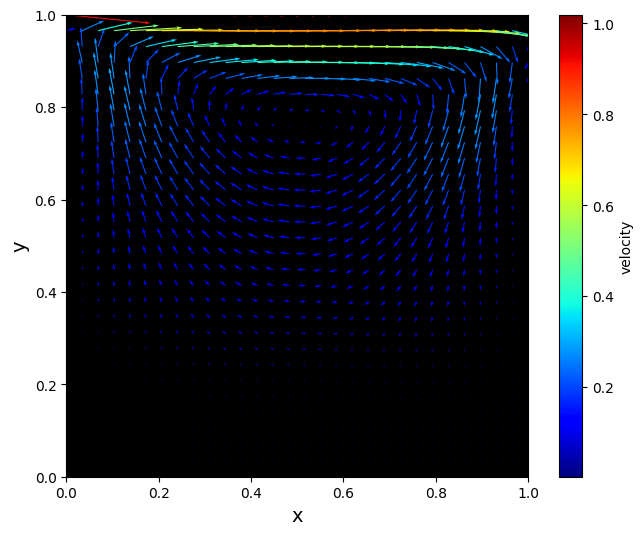

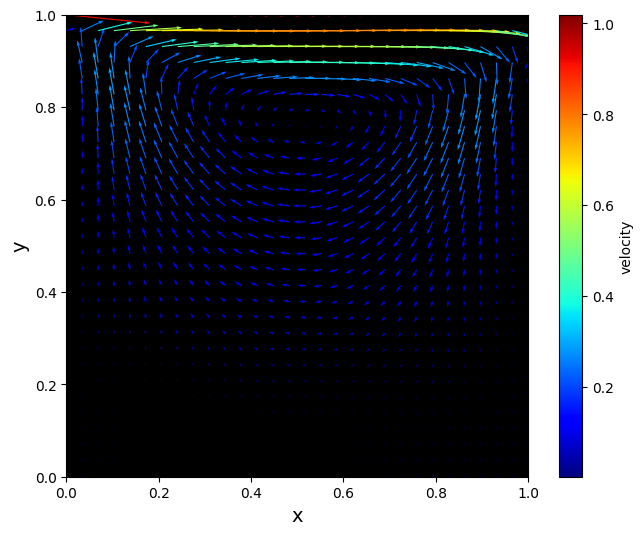

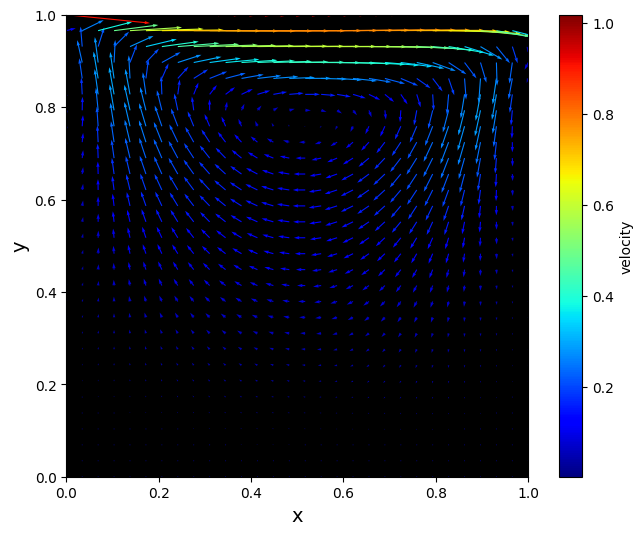

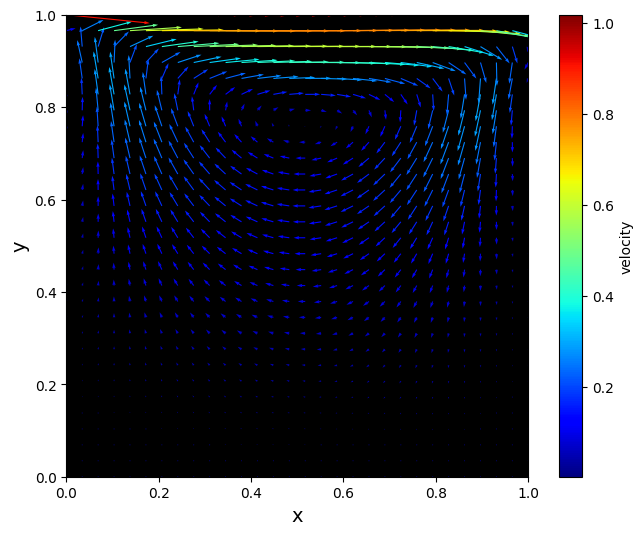

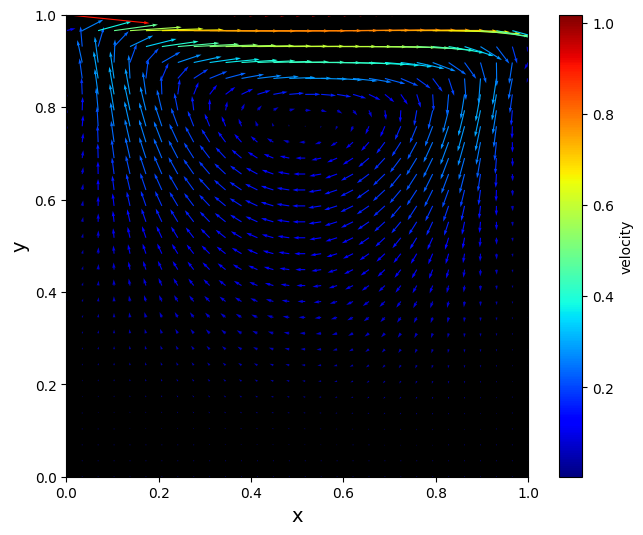

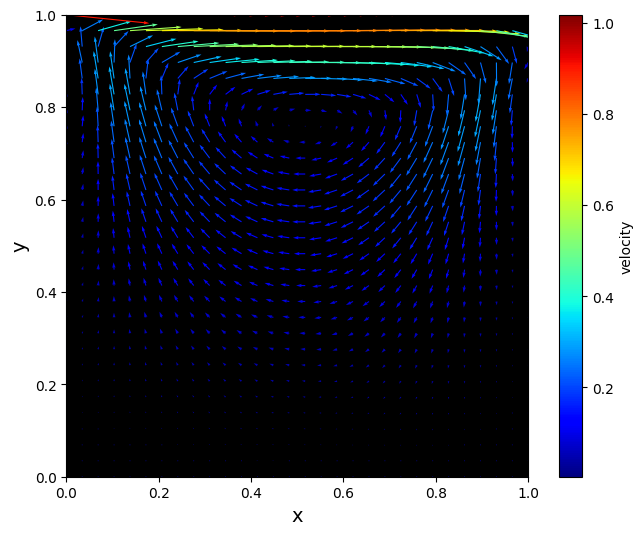

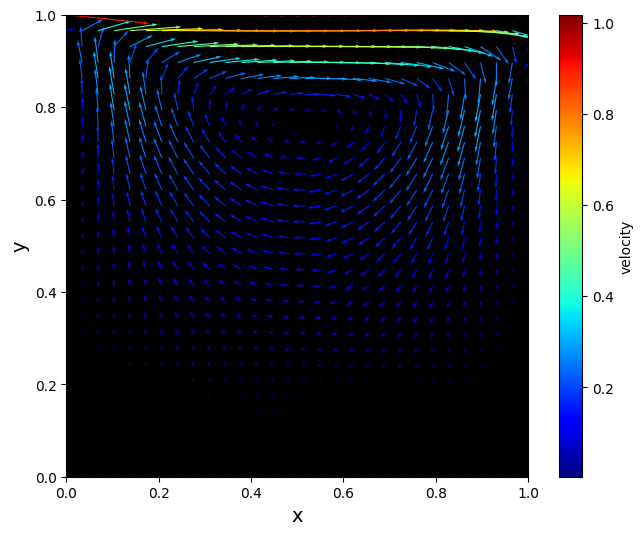

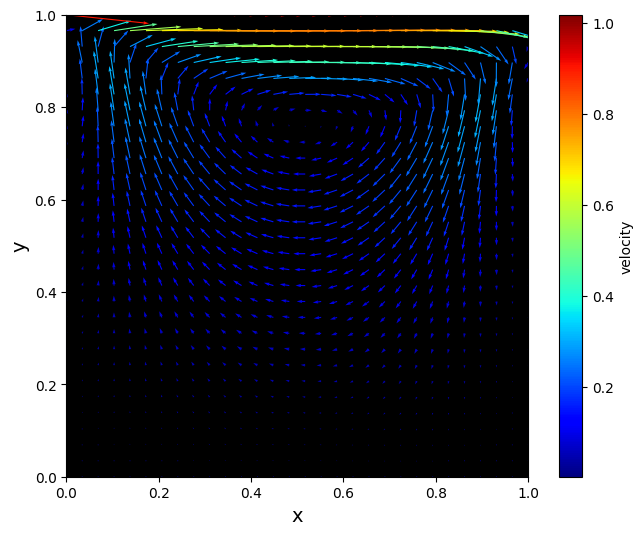

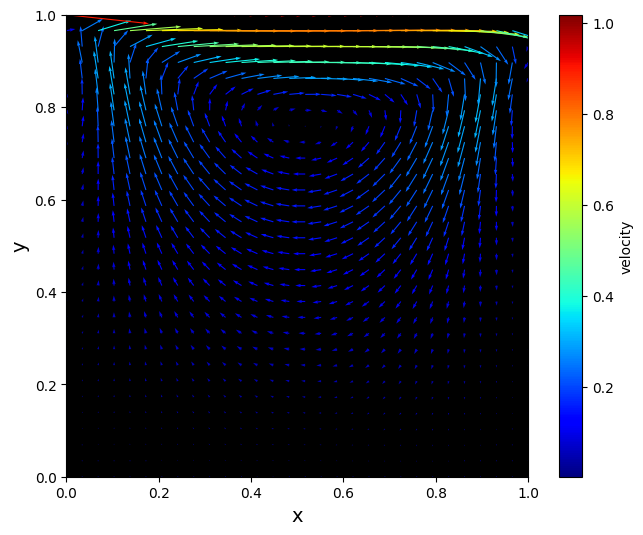

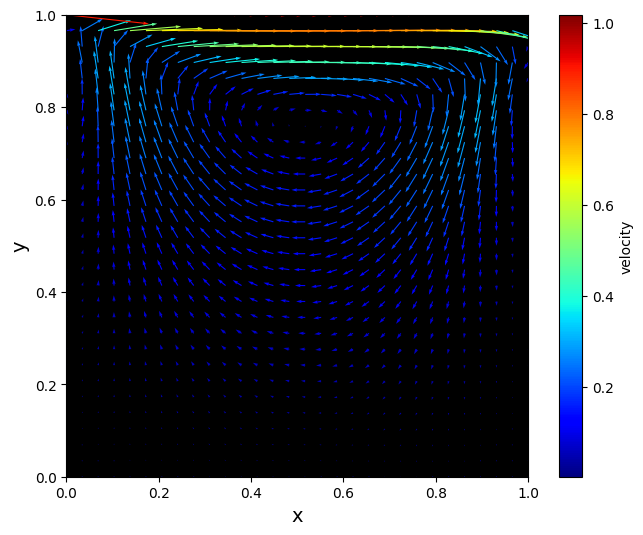

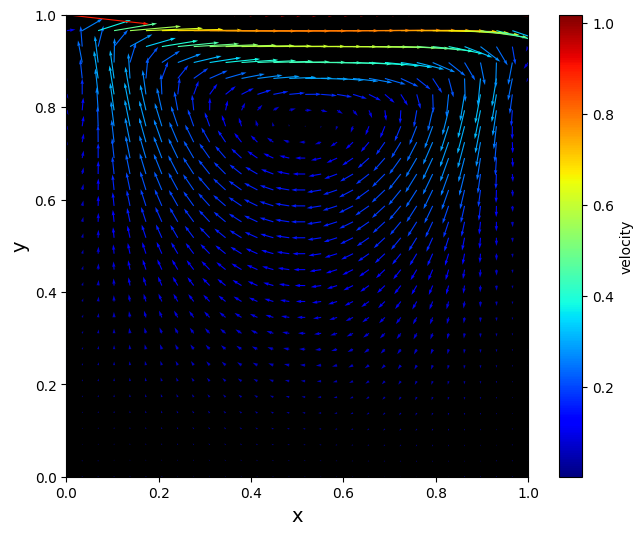

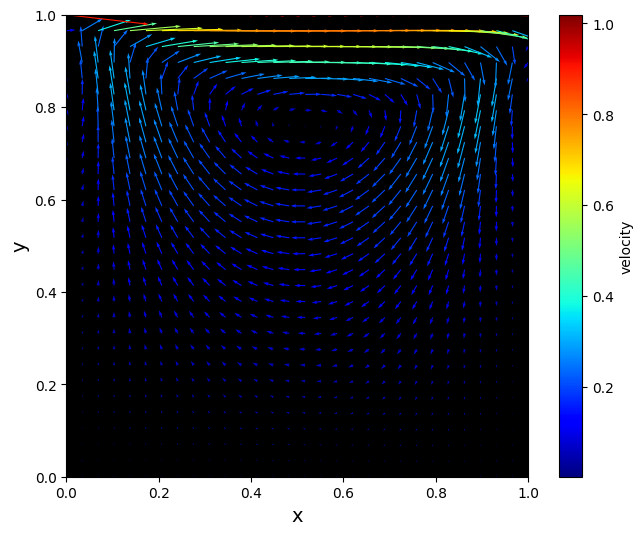

In [14]:
for i in range(0,31):
    ii = i*0.01
    x = np.linspace(0, 1, 30)
    y = np.linspace(0, 1, 30)
    X, Y = np.meshgrid(x, y)

    temp = np.concatenate([X.reshape((-1,1)),Y.reshape((-1,1)), np.full((len(X.reshape((-1,1))),1),ii)], axis=1)
    u, v, p = model.predict(temp)
    
    fig = plot_Vector2D(X.reshape((-1,1)), Y.reshape((-1,1)), u, v, scale=0.2)
    fig.savefig("./temp/vector_{}.png".format(i))

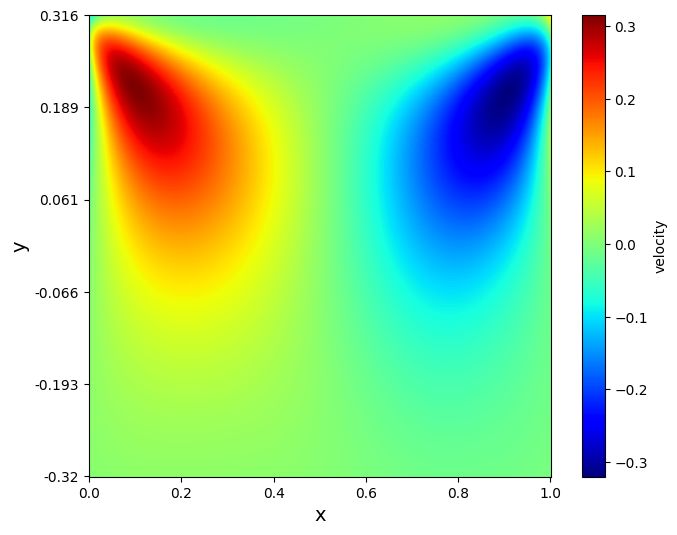

In [15]:
x = np.linspace(0, 1, 500)
y = np.linspace(0, 1, 500)
X, Y = np.meshgrid(x, y)

temp = np.concatenate([X.reshape((-1,1)),Y.reshape((-1,1)), np.full((len(X.reshape((-1,1))),1),0.3)], axis=1)
u, v, p = model.predict(temp)

plot_Scalar2D(X.reshape((-1,1)), v.reshape((-1,1)), np.flipud(v.reshape(500,500)), split=5)

In [16]:
from PIL import Image
import os

fig_path = './temp'

im_list = []
for i in range(0,31):
    file = "vector_{}.png".format(i)
    file_path = os.path.join(fig_path, file)
    im = Image.open(file_path)
    im_list.append(im)

im_list[0].save("animation.gif", save_all=True, append_images=im_list[1:])

TypeError: 'PngImageFile' object is not iterable

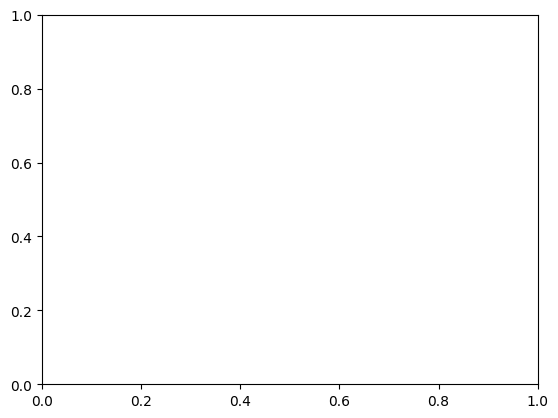

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()
ax = fig.add_subplot(111)
#Line2D objectを入れるリスト
ims = []

for file in sorted(os.listdir(fig_path)):
    file_path = os.path.join(fig_path, file)
    im = Image.open(file_path)
    ims.append(im) #各フレーム画像をimsに追加

#アニメの生成
ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)

#保存
ani.save("sample.gif", writer="pillow")

#表示
plt.show()

# Test and Debug

# Industrial Waste

In [ ]:
def sample_from_Rectangular(
    num_sampling, 
    x_size,
    y_size,
    z_size,
    x_min = 0,
    y_min = 0,
    z_min = 0
):
    """
    sample points from recranglar region.
    
    Args:
        num_sampling : int / number of sampling points
        x_size : int or float / rectangular length for x
        y_size : int or float / rectangular length for y
        z_size : int or float / rectangular length for z
        x_min = 0 : int or float / minimum value of x sampling range. sample from [x_min, x_min+x_size]
        y_min = 0 : int or float / minimum value of y sampling range. sample from [y_min, y_min+y_size]
        z_min = 0 : int or float / minimum value of z sampling range. sample from [z_min, z_min+z_size]

    Returns:
        points_array: np.ndarray / set of points
    """

    
    points_array = np.empty(shape=(0,3))

    for i in range(num_sampling):
        new_data = np.random.rand(1,3) * np.array([[x_size, y_size, z_size]]) - np.array([[x_min, y_min, z_min]])
        points_array = np.concatenate([points_array, new_data], axis=0)

    return points_array



def sample_from_Square(
    num_sampling, 
    x_size,
    y_size,
    x_min = 0,
    y_min = 0,
):
    """
    sample points from square region.

    Args:
        num_sampling : int / number of sampling points
        x_size : int or float / rectangular length for x
        y_size : int or float / rectangular length for y
        x_min : int or float / minimum value of x sampling range. sample from [x_min, x_min+x_size]
        y_min : int or float / minimum value of y sampling range. sample from [y_min, y_min+y_size]

    Returns:
        points_array: np.ndarray / set of points
    """

    
    points_array = np.empty(shape=(0,2))

    for i in range(num_sampling):
        new_data = np.random.rand(1,2) * np.array([[x_size, y_size]]) - np.array([[x_min, y_min]])
        points_array = np.concatenate([points_array, new_data], axis=0)

    return points_array



def sample_from_Line(
    num_sampling, 
    x_size,
    x_min = 0,
):
    """
    sample points from line region.

    Args:
        num_sampling : int or float / number of sampling points
        x_size : int or float / rectangular length for x
        x_min : int or float / minimum value of x sampling range. sample from [x_min, x_min+x_size]

    Returns:
        points_array: np.ndarray / set of points
    """

    
    points_array = np.empty(shape=(0,1))

    for i in range(num_sampling):
        new_data = np.random.rand(1,1) * np.array([[x_size]]) - np.array([[x_min]])
        points_array = np.concatenate([points_array, new_data], axis=0)

    return points_array